In [1]:
import sqlite3
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint


from sklearn.tree import export_graphviz
from IPython.display import Image

In [2]:
if os.getenv("SNAKEMAKE_EXECUTION"):
    # Adjust paths for Snakemake execution
    output = "./05-logistic_regression/roc.png"
    db_path = "./unified-final.db"
else:
    # Adjust paths for local execution
    output = "roc.png"
    db_path = "../unified-final.db"

con = sqlite3.connect(db_path)
cur = con.cursor()
df = pd.read_sql_query("SELECT * FROM prod_desc", con)

df['AB'] = df['AB'].apply(lambda x: int.from_bytes(x, 'little'))# converting binary to dec int

In [3]:

df.head(3)


,level_0,index,id,name,AB,description,OX,source,seq,valid,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0.0,b'\x00\x00\x00\x00\x00\x00\x00\x00',ADAM_2177,InverPep_ADAM_2177,b'\x01\x00\x00\x00\x00\x00\x00\x00',None,alien,InverPep.fasta,GLFNVFKGLKTAGKHVAGSLLNQLKCKVSGGC,yes,...,0,0,0,0,0,0,0,0,5,0
1,NaN,b'\x981\x00\x00\x00\x00\x00\x00',P85402,UP04_GINBI,b'\x00\x00\x00\x00\x00\x00\x00\x00',Unknown protein 4 (Fragment),Ginkgo biloba OX=3311,uniprot_swissprot.fasta,GDAAAQPEK,yes,...,0,0,0,0,0,0,0,0,1,0
2,NaN,b'\x991\x00\x00\x00\x00\x00\x00',P85403,UP05_GINBI,b'\x00\x00\x00\x00\x00\x00\x00\x00',Unknown protein 5 (Fragment),Ginkgo biloba OX=3311,uniprot_swissprot.fasta,NNQLNASHK,yes,...,0,0,0,0,0,0,0,0,1,0


In [4]:
df['fr_term_acetylene'].unique()

array([0])

In [5]:
#reformatting AB to int
df['AB'] = df['AB'].apply(lambda x: int.from_bytes(x, 'little'))

In [6]:
# dropping unique descriptors
descriptors = df.columns[9:]
unidescriptors = [d for d in descriptors if len(df[d].unique()) < 2]
print('len desc, len unidesc', len(descriptors), len(unidescriptors))
print(df.shape)
df.drop(unidescriptors, axis = 1, inplace = True)
print(df.shape)


len desc, len unidesc 211 70
(11521, 220)
(11521, 150)


In [10]:
df.columns

Index(['level_0', 'index', 'id', 'name', 'AB', 'description', 'OX', 'source',
       'seq', 'MaxAbsEStateIndex',
       ...
       'fr_benzene', 'fr_bicyclic', 'fr_guanido', 'fr_imidazole',
       'fr_para_hydroxylation', 'fr_phenol', 'fr_phenol_noOrthoHbond',
       'fr_priamide', 'fr_sulfide', 'fr_unbrch_alkane'],
      dtype='object', length=150)

In [11]:
#X = df.drop(['AB', 'index', 'id', 'name', 'valid', 'source', 'seq', 'description', 'OX'], axis = 1)
X = df.drop(['AB', 'index', 'id', 'name', 'source', 'seq', 'description', 'OX'], axis = 1)
y = df['AB']
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(X.mean(), inplace=True)
X = X.clip(lower=-1e38, upper=1e38)
X_float = X.astype(np.float32)

#split into test and train

X_train, X_test, y_train, y_test = train_test_split(X_float, y, test_size = 0.30, random_state = 42)



In [12]:
#param_dist = {'n_estimators': randint(50,500),
#             'max_depth': randint(1,20)}
# output from this is basis for next used parameter distribution 

param_dist = {'n_estimators': randint(400,500),
              'max_depth': randint(16,20)}

rf = RandomForestClassifier(random_state = 1)

rand_search = RandomizedSearchCV(rf,
                                 param_distributions = param_dist,
                                 n_iter = 5,
                                 cv = 5)

rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1),
                   n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fe96ec70430>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fe95642b190>})

In [13]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_
y_pred = best_rf.predict(X_test)

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

# random component leads to different outcomes, also with set seed!
# for reproducability when rerunning we fix hyperparameters


Best hyperparameters: {'max_depth': 19, 'n_estimators': 432}


In [15]:
# for reproducability hyperparameters are fixed now
# if restarting use parameters: 'n_estimators': 432, 'max_depth': 19

best_rf = RandomForestClassifier(random_state=1, n_estimators=432, max_depth=19)
best_rf = best_rf.fit(X_train, y_train)

y_pred = best_rf.predict(X_test)


In [16]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.8206537460225629
Precision: 0.833762223365929
Recall: 0.8450704225352113


In [17]:
import matplotlib.pyplot as plt

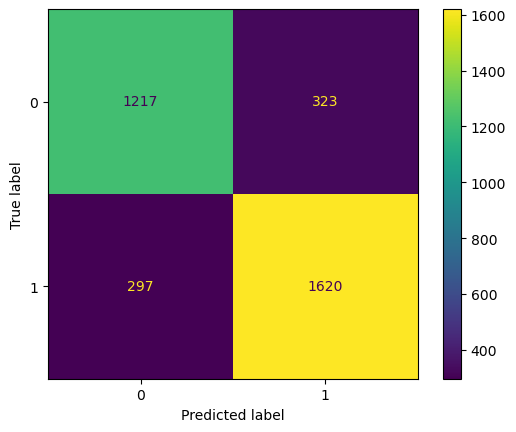

In [18]:
# Generate predictions with the best model
y_pred = best_rf.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()
#plt.savefig('final_RF_confmatrix.png', dpi = 900, bbox_inches = "tight")


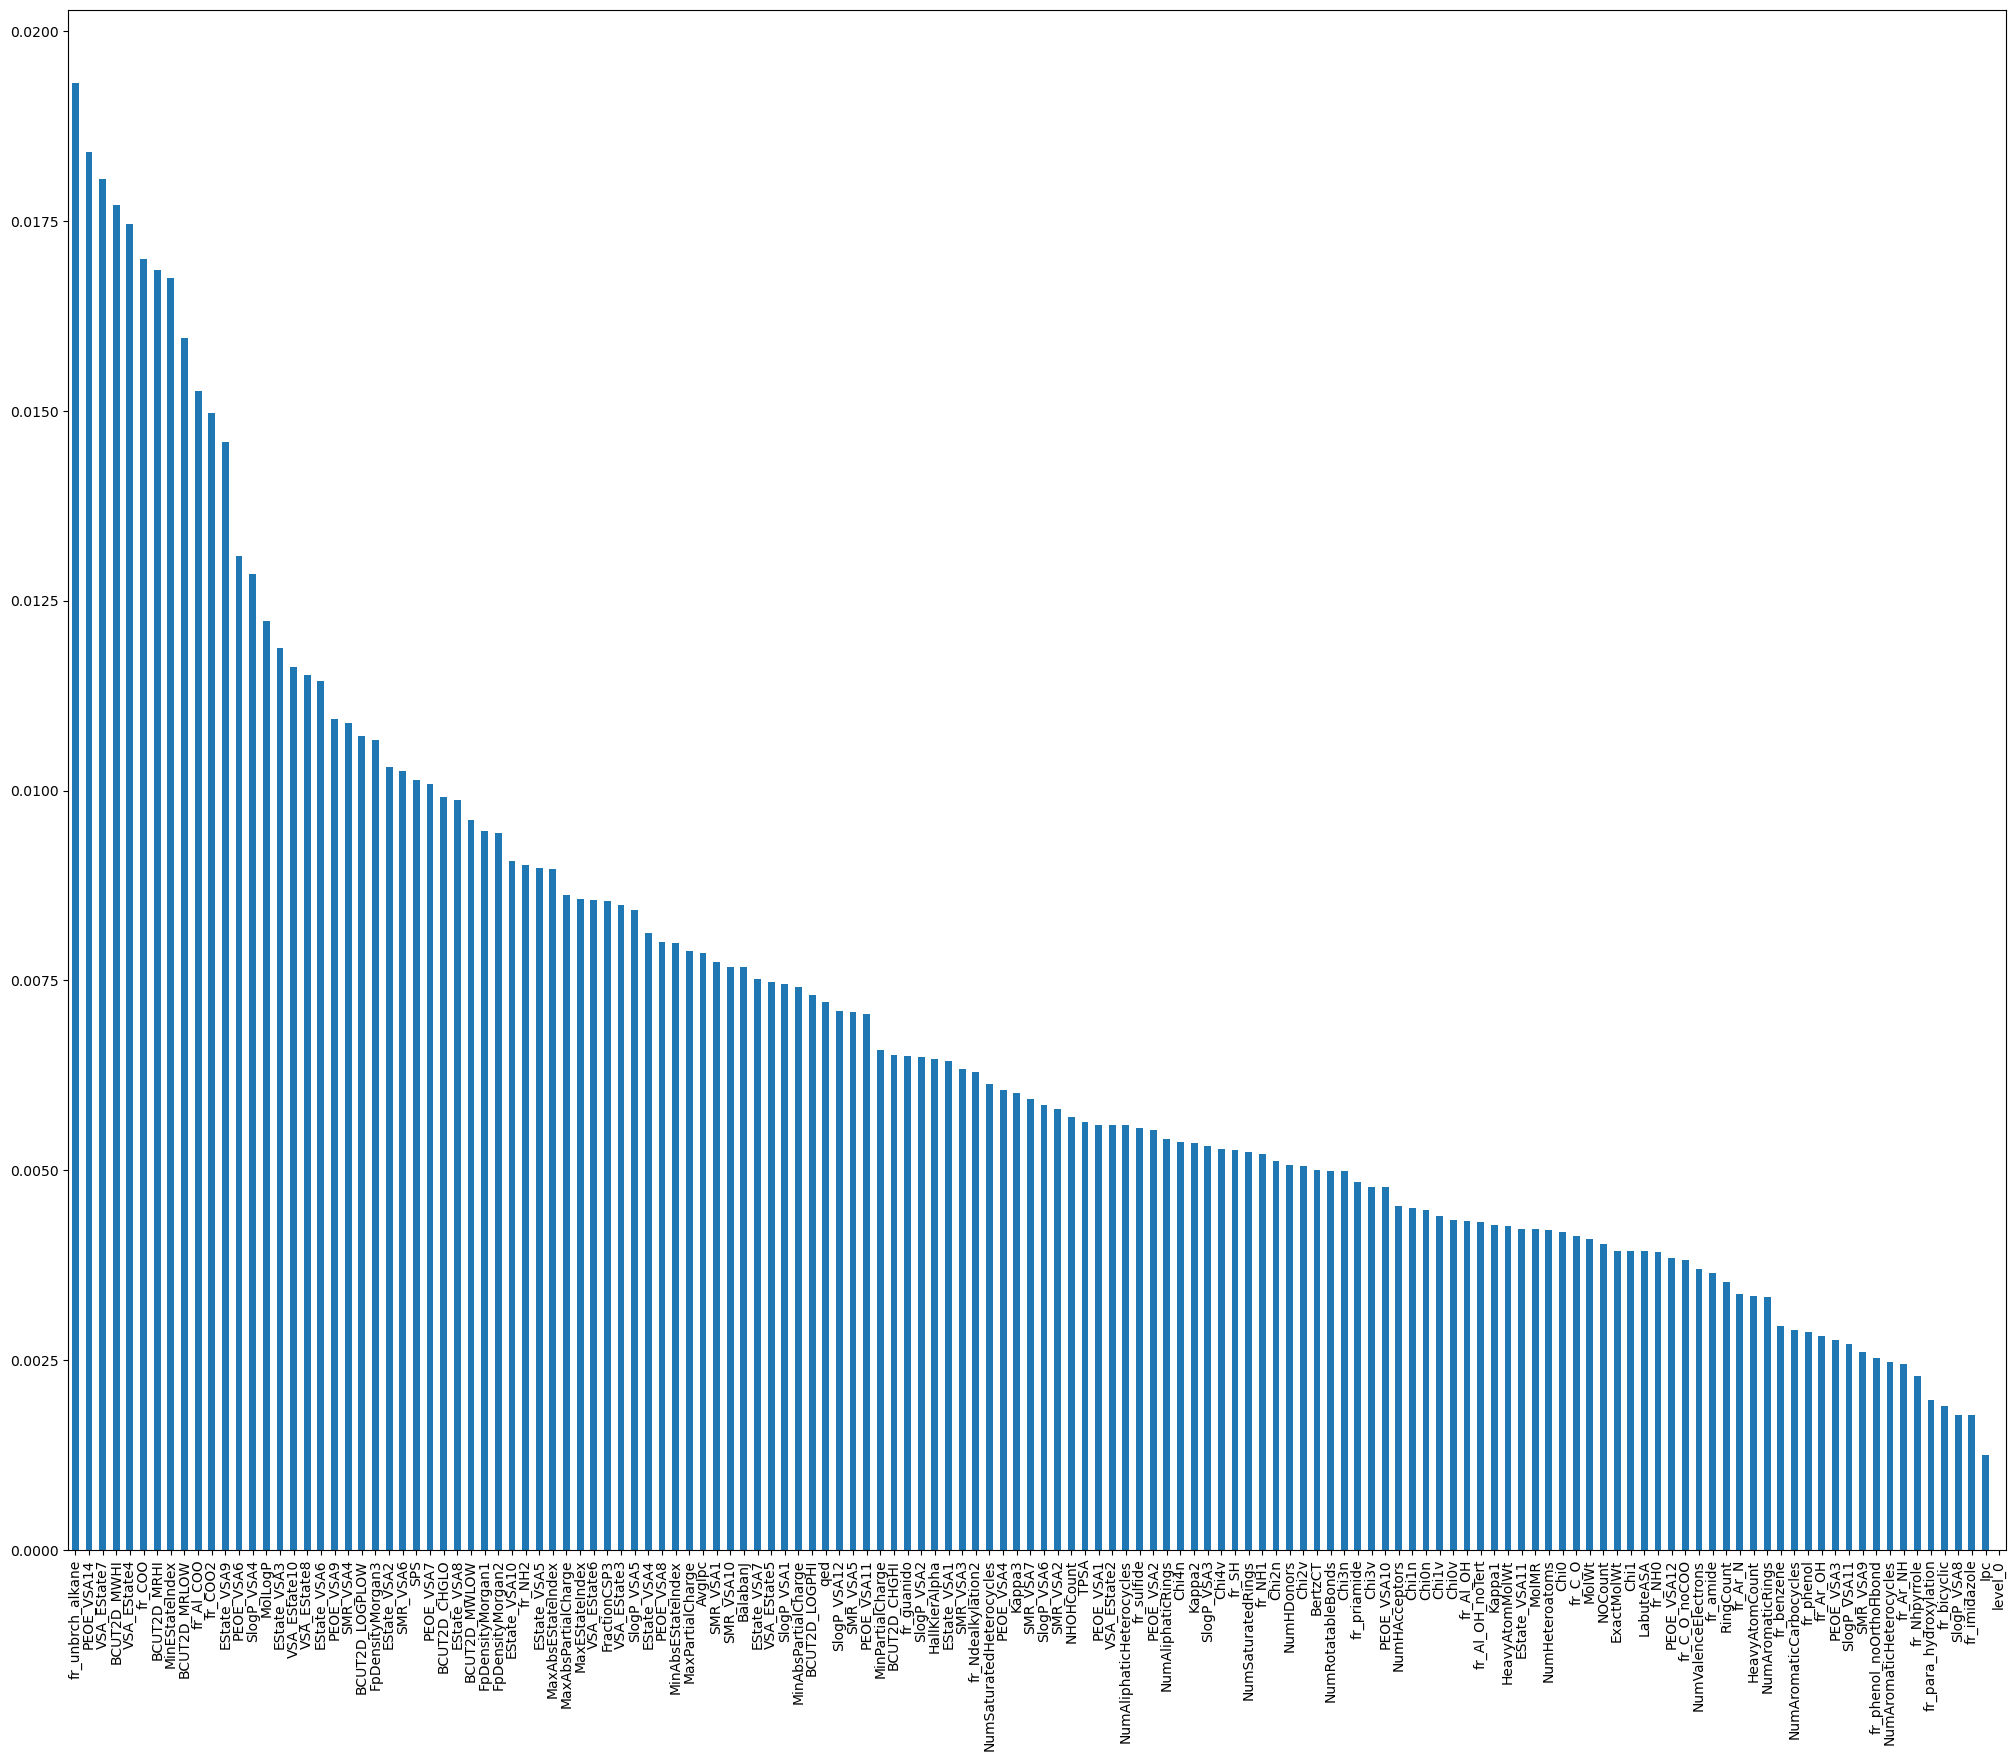

In [20]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar(width = 0.5, figsize =(25, 20))
#plt.savefig('final_RF_featureimportance.png', dpi = 900, bbox_inches = "tight")


In [21]:
from sklearn.metrics import roc_curve, roc_auc_score 


y_pred_prob = best_rf.predict_proba(X_test)[:, 1] 
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)

roc_auc = roc_auc_score(y_test, y_pred_prob) 
print('roc_auc: ', roc_auc)

roc_auc:  0.8991907675006267


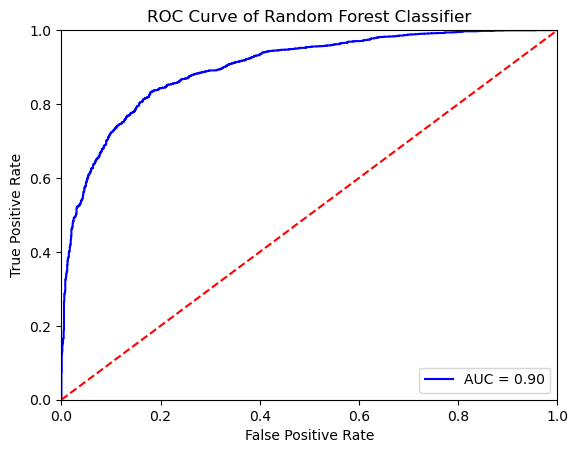

In [22]:

import matplotlib.pyplot as plt

plt.title('Receiver Operating Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of Random Forest Classifier')

#plt.savefig('final_RF_ROC.png', dpi = 900, bbox_inches = "tight")

plt.show()
plt.savefig(output)

In [23]:
X_test.corr()

best_rf.feature_importances_

array([0.        , 0.00897253, 0.00857668, 0.00798727, 0.01675407,
       0.007215  , 0.010138  , 0.00409138, 0.00426526, 0.00393463,
       0.00369916, 0.00789273, 0.00658475, 0.00862922, 0.00741125,
       0.00946309, 0.00944161, 0.0106613 , 0.01771284, 0.00961965,
       0.0065233 , 0.00992075, 0.00730889, 0.01072431, 0.01686227,
       0.0159581 , 0.0078591 , 0.00768155, 0.00500939, 0.00418511,
       0.00448181, 0.0043411 , 0.00393168, 0.00450457, 0.00439441,
       0.00512342, 0.00506169, 0.00498954, 0.00478652, 0.00536675,
       0.00528009, 0.00646552, 0.00124806, 0.00428512, 0.00535857,
       0.00601725, 0.0039313 , 0.00560296, 0.0047849 , 0.00705379,
       0.00384856, 0.01841303, 0.00553687, 0.00277121, 0.00605877,
       0.01309087, 0.01008769, 0.00801162, 0.01093847, 0.00774521,
       0.00768424, 0.00580625, 0.00633207, 0.01089233, 0.00708559,
       0.0102598 , 0.00593617, 0.00260637, 0.00745955, 0.00271773,
       0.00709908, 0.00648715, 0.00532068, 0.01285927, 0.00843

In [24]:
best_rf.estimators_

[DecisionTreeClassifier(max_depth=19, max_features='sqrt',
                        random_state=1791095845),
 DecisionTreeClassifier(max_depth=19, max_features='sqrt',
                        random_state=2135392491),
 DecisionTreeClassifier(max_depth=19, max_features='sqrt',
                        random_state=946286476),
 DecisionTreeClassifier(max_depth=19, max_features='sqrt',
                        random_state=1857819720),
 DecisionTreeClassifier(max_depth=19, max_features='sqrt', random_state=491263),
 DecisionTreeClassifier(max_depth=19, max_features='sqrt',
                        random_state=550290313),
 DecisionTreeClassifier(max_depth=19, max_features='sqrt',
                        random_state=1298508491),
 DecisionTreeClassifier(max_depth=19, max_features='sqrt',
                        random_state=2143362693),
 DecisionTreeClassifier(max_depth=19, max_features='sqrt',
                        random_state=630311759),
 DecisionTreeClassifier(max_depth=19, max_features